In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Real Beam Parameters (for plotting & comparison)
L_real = 2.0         # Beam length (m)
EI_real = 135245     # Flexural rigidity
P_real = 500         # Point load at tip
P_mid_real = 300    # Point load at the midpoint

# Normalize to unitless problem
L = 1.0              # normalized length
EI = 1.0             # normalized EI
P = 1.0              # normalized P
P_mid = P_mid_real/P_real         # normalized P_mid

# Scale factors for un-normalization
x_scale = L_real / L
w_scale = (P_real * L_real**3) / (EI_real * L**3)

# Define Neural Network
class PINN_Cantilever(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

In [2]:
# Compute nth derivative
def get_derivative(y, x, n):
    for _ in range(n):
        y = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return y

# Loss Function
def loss_fn(model, x_interior):
    x_interior.requires_grad = True
    w = model(x_interior)
    w_4th = get_derivative(w, x_interior, 4)
    loss_pde = torch.mean(w_4th ** 2)


    x0 = torch.tensor([[0.0]], requires_grad=True)
    xL = torch.tensor([[L]], requires_grad=True)

    x05 = torch.tensor([[0.5]], requires_grad=True)

    w0 = model(x0)
    dw0 = get_derivative(w0, x0, 1)
    d2w0 = get_derivative(w0, x0, 2)
    d3w0 = get_derivative(w0, x0, 3)
    d2w05 = get_derivative(model(x05), x05, 2)
    d3w05 = get_derivative(model(x05), x05, 3)
    d2wL = get_derivative(model(xL), xL, 2)
    d3wL = get_derivative(model(xL), xL, 3)

    ## 

    loss_bc = w0.pow(2) + dw0.pow(2) + d2wL.pow(2) + (d3wL + P / EI).pow(2)

    loss_interface = (d2w05 - (P * (L/2)) / EI).pow(2) + (d3wL + (P + P_mid) / EI)

    return loss_pde + loss_bc + loss_interface


Epoch 0, Loss = 2.821395
Epoch 100, Loss = 0.383486
Epoch 200, Loss = 0.377646


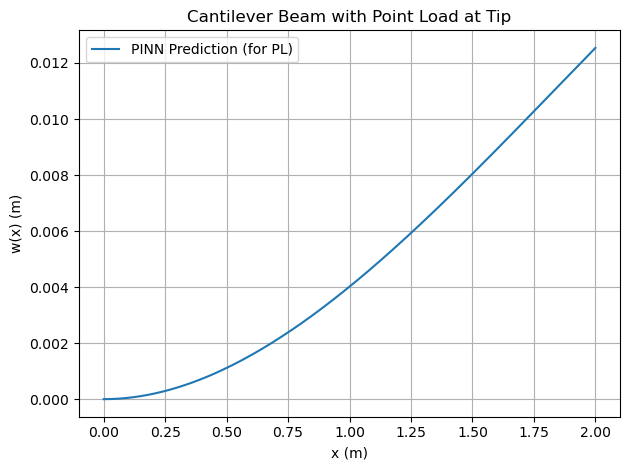

In [3]:
# Initialize
model = PINN_Cantilever()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training Data (normalized domain)
x_train = torch.linspace(0, L, 50).view(-1, 1).float()

# Training Loop
for epoch in range(300):
    optimizer.zero_grad()
    loss = loss_fn(model, x_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6f}")

# Evaluation
x_eval_norm = torch.linspace(0, L, 200).view(-1, 1)
x_eval_norm.requires_grad = True
w_pred_norm = model(x_eval_norm).detach().numpy()

# Unscale for plotting
x_vals = x_eval_norm.detach().numpy() * x_scale
w_pred = w_pred_norm * w_scale

# Analytical Solution (in real units)
#w_exact = (P_real * x_vals**2 / (6 * EI_real)) * (3*L_real - x_vals)

# Plot
plt.plot(x_vals, w_pred, label="PINN Prediction (for PL)")
#plt.plot(x_vals, w_exact, '--', label="Analytical Solution (for PL)")
plt.xlabel("x (m)")
plt.ylabel("w(x) (m)")
plt.title("Cantilever Beam with Point Load at Tip")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

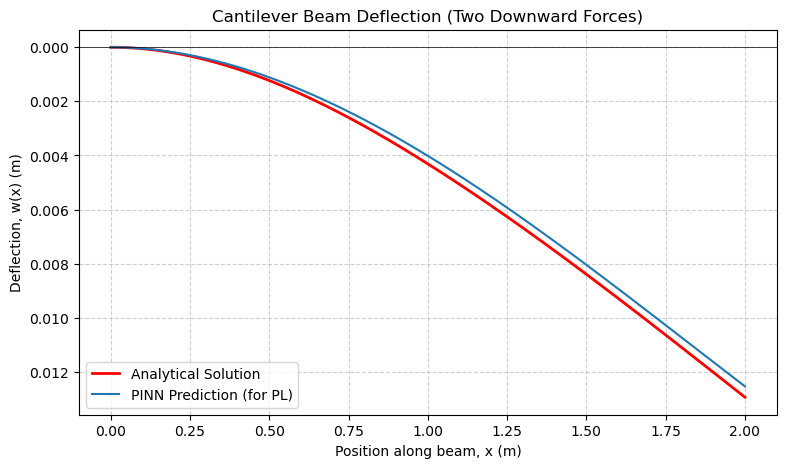


Maximum deflection at the tip (x=2.0m): 0.012939 m


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def analytical_solution(x_points, P_tip, P_mid, L, EI):
    """
    Calculates the analytical deflection of a cantilever beam with a tip load
    and a midpoint load using the principle of superposition.

    Args:
        x_points (np.ndarray): Points along the beam to calculate deflection.
        P_tip (float): Force at the tip of the beam (at x=L).
        P_mid (float): Force at the midpoint of the beam (at x=L/2).
        L (float): Length of the beam.
        EI (float): Flexural rigidity of the beam.

    Returns:
        np.ndarray: The deflection w(x) at each point in x_points.
    """
    # Deflection caused by the tip load P_tip
    w_tip = (P_tip * x_points**2) / (6 * EI) * (3 * L - x_points)

    # Deflection caused by the midpoint load P_mid (piecewise function)
    a = L / 2.0
    w_mid_part1 = (P_mid * x_points**2) / (6 * EI) * (3 * a - x_points)
    w_mid_part2 = (P_mid * a**2) / (6 * EI) * (3 * x_points - a)
    w_mid = np.where(x_points <= a, w_mid_part1, w_mid_part2)

    # The total deflection is the sum of the deflections from each load
    return w_tip + w_mid

# ==============================================================================
# Main script to run and plot the solution
# ==============================================================================
if __name__ == '__main__':
    # --- Beam Parameters ---
    L_real = 2.0      # Beam length (m)
    EI_real = 135245  # Flexural rigidity (N*m^2)
    P_tip_real = 500  # Point load at tip (N)
    P_mid_real = 500  # Point load at the midpoint (N)

    # --- Generate points for plotting ---
    x_values = np.linspace(0, L_real, 200)

    # --- Calculate the analytical solution ---
    w_analytical = analytical_solution(x_values, P_tip_real, P_mid_real, L_real, EI_real)

    # --- Plot the results ---
    plt.figure(figsize=(9, 5))
    plt.plot(x_values, w_analytical, label='Analytical Solution', color='red', linewidth=2)
    plt.plot(x_vals, w_pred, label="PINN Prediction (for PL)")
    plt.title('Cantilever Beam Deflection (Two Downward Forces)')
    plt.xlabel('Position along beam, x (m)')
    plt.ylabel('Deflection, w(x) (m)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # Invert y-axis to show downward deflection going down
    plt.gca().invert_yaxis()
    plt.axhline(0, color='black', linewidth=0.5)
    
    plt.show()

    # Print the maximum deflection value at the tip
    max_deflection = w_analytical[-1]
    print(f"\nMaximum deflection at the tip (x={L_real}m): {max_deflection:.6f} m")

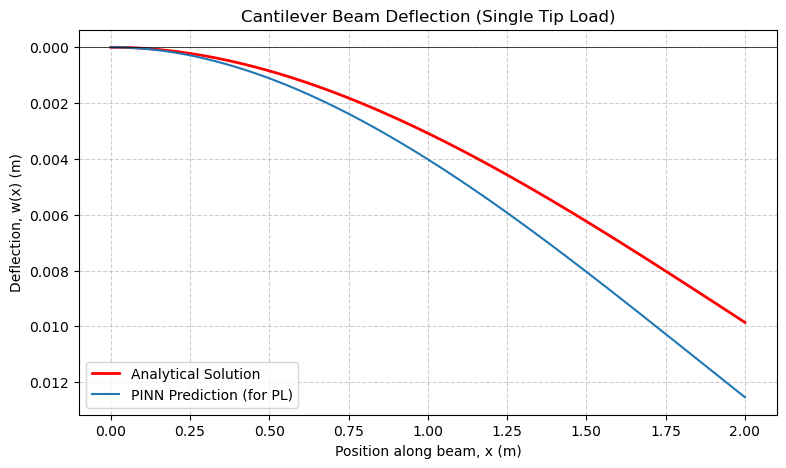


Maximum deflection at the tip (x=2.0m): 0.009859 m


In [5]:
def analytical_solution_tip_load(x_points, P, L, EI):
    """
    Calculates the analytical deflection of a cantilever beam with a single
    point load at the free end.

    Args:
        x_points (np.ndarray): Points along the beam to calculate deflection.
        P (float): Force at the tip of the beam (at x=L).
        L (float): Length of the beam.
        EI (float): Flexural rigidity of the beam.

    Returns:
        np.ndarray: The deflection w(x) at each point in x_points.
    """
    # Standard formula for deflection from a tip load
    w_analytical = (P * x_points**2) / (6 * EI) * (3 * L - x_points)
    
    return w_analytical

# ==============================================================================
# Main script to run and plot the solution
# ==============================================================================
if __name__ == '__main__':
    # --- Beam Parameters ---
    L_real = 2.0      # Beam length (m)
    EI_real = 135245  # Flexural rigidity (N*m^2)
    P_real = 500      # Point load at tip (N)

    # --- Generate points for plotting ---
    x_values = np.linspace(0, L_real, 200)

    # --- Calculate the analytical solution ---
    w_analytical = analytical_solution_tip_load(x_values, P_real, L_real, EI_real)

    # --- Plot the results ---
    plt.figure(figsize=(9, 5))
    plt.plot(x_values, w_analytical, label='Analytical Solution', color='red', linewidth=2)
    plt.plot(x_vals, w_pred, label="PINN Prediction (for PL)")
    plt.title('Cantilever Beam Deflection (Single Tip Load)')
    plt.xlabel('Position along beam, x (m)')
    plt.ylabel('Deflection, w(x) (m)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # Invert y-axis to show downward deflection going down
    plt.gca().invert_yaxis()
    plt.axhline(0, color='black', linewidth=0.5)
    
    plt.show()

    # Print the maximum deflection value at the tip
    max_deflection = w_analytical[-1]
    print(f"\nMaximum deflection at the tip (x={L_real}m): {max_deflection:.6f} m")